# MNIST challenge with Keras

## Import libs

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

print("Pandas", pd.__version__)
print("NumPy", np.__version__)

Using TensorFlow backend.


Pandas 0.23.4
NumPy 1.13.3


## Hyperparameters

In [2]:
img_size = 28
batch_size = 64
validation_split = 0.1
epochs = 15

## Prepare data

### Load data to Pandas

In [3]:
train_raw_dataset = pd.read_csv("digit-recognizer/train.csv")
test_raw_dataset = pd.read_csv("digit-recognizer/test.csv")
sample_submission = pd.read_csv("digit-recognizer/sample_submission.csv")

### Preprocess data to NumPy trainable data

In [17]:
def preprocess(train_raw_dataset, test_raw_dataset):
    # Work with train data
    X_train = train_raw_dataset.drop(["label"], axis=1)
    X_train = X_train.values.astype("float32")
    X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
    X_train /= 255
    X_train = X_train.clip(0, 1)

    y_train = train_raw_dataset["label"]
    y_train = y_train.values
    y_train = np_utils.to_categorical(y_train, 10)
    
    # Split to train/validation set
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, 
        y_train, 
        test_size=validation_split, 
        shuffle=True
    )
    
    # Work with test data
    X_test = test_raw_dataset.values.astype("float32")
    X_test = X_test.reshape(X_test.shape[0], img_size, img_size, 1)
    X_test /= 255
    X_test = X_test.clip(0, 1)
    
    return X_train, X_valid, y_train, y_valid, X_test

X_train, X_valid, y_train, y_valid, X_test = preprocess(train_raw_dataset, test_raw_dataset)

### Plot data

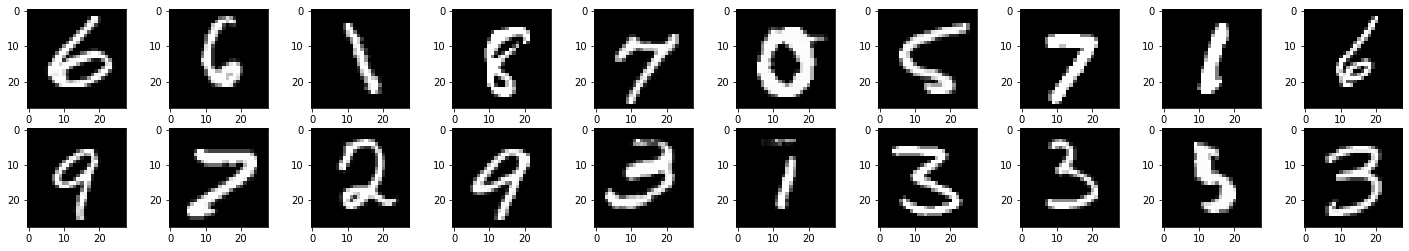

In [5]:
fig = plt.figure(figsize=(25, 4))
for i in range(20):
    ax = fig.add_subplot(2, 10, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')

### Data augmentation

(!) Experiments show, that digits are very sensitive to augmentation, so it should change digits a little

In [6]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    data_format="channels_last",
    validation_split=validation_split
)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

datagen_flow = datagen.flow(X_train, y_train, batch_size=batch_size)

### Plot augmented data

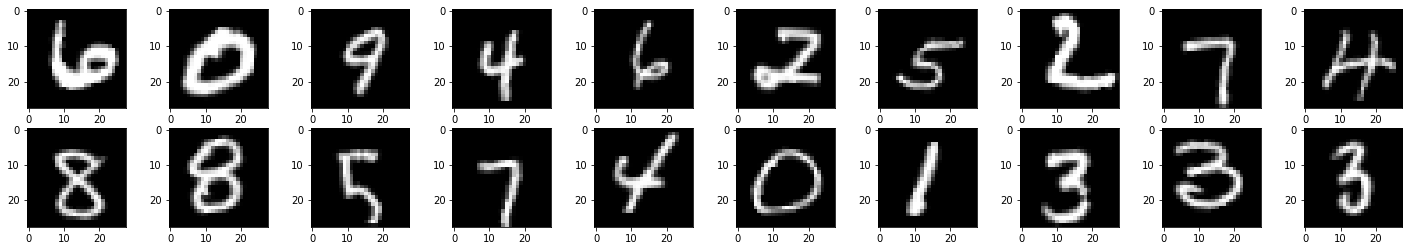

In [7]:
fig = plt.figure(figsize=(25, 4))
for X_batch, y_batch in datagen_flow:
    for i in range(20):
        ax = fig.add_subplot(2, 10, i+1)
        plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.show()
    break

---

## Prepare model

### Create

In [8]:
input_shape = (img_size, img_size, 1)

model = Sequential()
model.add(Convolution2D(32, (5, 5), padding="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
model.add(Convolution2D(64, (5, 5), padding="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
__________

### Train

In [10]:
# for model saving
callbacks=[ModelCheckpoint(
    "checkpoints/mnist_model.hdf5", 
    monitor="val_acc", 
    save_best_only=True, 
    save_weights_only=False, 
    mode="auto"
)]

train_history = model.fit_generator(
    datagen_flow, 
    epochs=epochs, 
    steps_per_epoch=(len(X_train) / batch_size), 
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

Epoch 1/15
591/590 [==============================] - 67s 113ms/step - loss: 0.2099 - acc: 0.9348 - val_loss: 0.0627 - val_acc: 0.9814
Epoch 2/15
591/590 [==============================] - 66s 111ms/step - loss: 0.0743 - acc: 0.9765 - val_loss: 0.0478 - val_acc: 0.9845
Epoch 3/15
591/590 [==============================] - 67s 113ms/step - loss: 0.0542 - acc: 0.9833 - val_loss: 0.0512 - val_acc: 0.9862
Epoch 4/15
591/590 [==============================] - 66s 111ms/step - loss: 0.0479 - acc: 0.9846 - val_loss: 0.0469 - val_acc: 0.9869
Epoch 5/15
591/590 [==============================] - 66s 111ms/step - loss: 0.0407 - acc: 0.9870 - val_loss: 0.0385 - val_acc: 0.9902
Epoch 6/15
591/590 [==============================] - 66s 112ms/step - loss: 0.0337 - acc: 0.9896 - val_loss: 0.0356 - val_acc: 0.9912
Epoch 7/15
591/590 [==============================] - 70s 118ms/step - loss: 0.0349 - acc: 0.9890 - val_loss: 0.0383 - val_acc: 0.9921
Epoch 8/15
591/590 [==============================] - 6

### Plot train results

Text(0, 0.5, 'Loss')

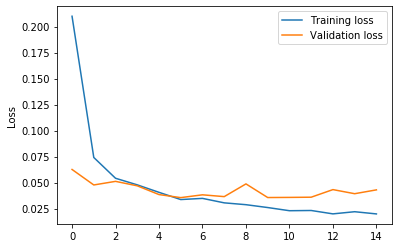

In [15]:
plt.plot(train_history.history["loss"], label="Training loss")
plt.plot(train_history.history["val_loss"], label="Validation loss")
plt.legend()
plt.ylabel('Loss')

Text(0, 0.5, 'Acc')

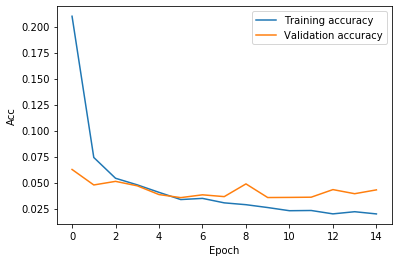

In [16]:
plt.plot(train_history.history["loss"], label="Training accuracy")
plt.plot(train_history.history["val_loss"], label="Validation accuracy")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Acc')

## Test
In order to check the results are proper

In [18]:
test = model.predict(X_test)
test_labels = np.argmax(test, axis = 1)

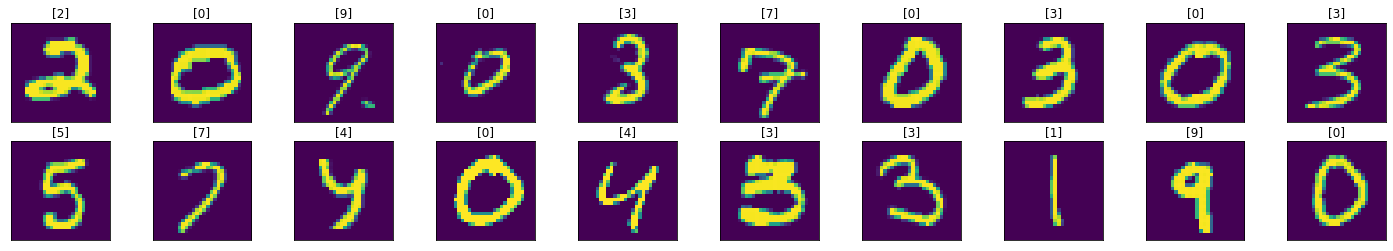

In [19]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(X_test[idx].reshape(28, 28))
    ax.set_label([test_labels[idx]])
    ax.set_title([test_labels[idx]])

# Submit

In [24]:
results = pd.Series(test_labels, name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"), results],axis = 1)
submission.to_csv("digit-recognizer/mnist_prediction.csv", index=False)